## XOR

In [123]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [126]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

model = Sequential()
model.add(Dense(4, input_shape=(2, ), activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [127]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.01), loss='mse', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 441ms/step - loss: 0.2669 - acc: 0.7500
Epoch 2/100
4/4 [==============================] - 0s 828us/step - loss: 0.2635 - acc: 0.7500
Epoch 3/100
4/4 [==============================] - 0s 928us/step - loss: 0.2596 - acc: 0.7500
Epoch 4/100
4/4 [==============================] - 0s 912us/step - loss: 0.2564 - acc: 0.7500
Epoch 5/100
4/4 [==============================] - 0s 967us/step - loss: 0.2536 - acc: 0.7500
Epoch 6/100
4/4 [==============================] - 0s 893us/step - loss: 0.2512 - acc: 0.7500
Epoch 7/100
4/4 [==============================] - 0s 888us/step - loss: 0.2487 - acc: 0.7500
Epoch 8/100
4/4 [==============================] - 0s 877us/step - loss: 0.2463 - acc: 0.7500
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 0.2438 - acc: 0.7500
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 0.2413 - acc: 0.7500
Epoch 11/100
4/4 [==============================] - 0s 952us/st

Epoch 89/100
4/4 [==============================] - 0s 818us/step - loss: 0.0097 - acc: 1.0000
Epoch 90/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0091 - acc: 1.0000
Epoch 91/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0085 - acc: 1.0000
Epoch 92/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0080 - acc: 1.0000
Epoch 93/100
4/4 [==============================] - 0s 927us/step - loss: 0.0075 - acc: 1.0000
Epoch 94/100
4/4 [==============================] - 0s 881us/step - loss: 0.0071 - acc: 1.0000
Epoch 95/100
4/4 [==============================] - 0s 755us/step - loss: 0.0067 - acc: 1.0000
Epoch 96/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0063 - acc: 1.0000
Epoch 97/100
4/4 [==============================] - 0s 863us/step - loss: 0.0060 - acc: 1.0000
Epoch 98/100
4/4 [==============================] - 0s 919us/step - loss: 0.0056 - acc: 1.0000
Epoch 99/100
4/4 [==============================] - 0s 1ms

In [79]:
model.predict(X)

array([[0.06221629],
       [0.92816895],
       [0.8637947 ],
       [0.14197446]], dtype=float32)

## Handwritten Alphanumeric Recognition

### 0. Imports

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:
import plaidml.keras
plaidml.keras.install_backend()

In [119]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras_sequential_ascii import keras2ascii # install with pip
from sklearn.metrics import confusion_matrix
%matplotlib inline

### 1. Load dataset

In [16]:
PATH = './'
DATA_FILE = 'binaryalphadigs.mat'

In [17]:
mat = loadmat(PATH + DATA_FILE)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

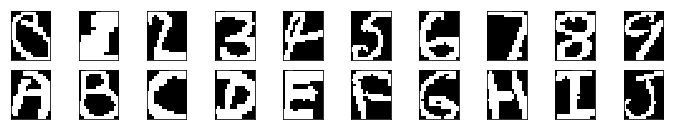

In [18]:
n = 20
plt.figure(figsize=(12, 2))
for i in range(n):
    ax = plt.subplot(2, n // 2, i + 1)
    plt.imshow(mat['dat'][i][0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
X = np.stack(mat['dat'].ravel(), axis=0)
X.shape

(1404, 20, 16)

In [20]:
classes = np.arange(mat['classlabels'].shape[1])
counts = np.stack(mat['classcounts'].ravel(), axis=0).ravel()

In [21]:
y = np.repeat(classes, counts).reshape(-1, 1)
y = to_categorical(y)
y.shape

(1404, 36)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 2. Run

In [121]:
img_shape = X.shape[1:]
num_classes = y.shape[1]
epochs = 50
history = []
conf_matrices = []

In [122]:
for batch_size in [64, 128]:
    for layers in [1, 2]:
        for neurons in [50, 100]:
            for lr in [0.07, 0.5]:
                for AF in ['relu', 'tanh']:
                    input_img = Input(img_shape)
                    x = Flatten()(input_img)
                    for i in range(layers):
                        x = Dense(neurons, activation=AF)(x)
                    x = Dense(num_classes, activation='softmax')(x)
                    model = Model(input_img, x)

                    sgd = SGD(lr=lr, decay=1e-6, momentum=0.7, nesterov=True)
                    model.compile(optimizer=sgd, loss='categorical_crossentropy', 
                                  metrics=['accuracy']) 
                    ret = model.fit(X_train, y_train,
                                    batch_size=batch_size, 
                                    validation_data=(X_test, y_test),
                                    epochs=epochs,
                                    shuffle=True, 
                                    verbose=1)
                    
                    y_pred = model.predict(X_test)
                    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
                    conf_matrices.append(matrix)
                    history.append([ret.history, layers, neurons, lr, batch_size, AF])

Train on 1053 samples, validate on 351 samples
Epoch 1/50
1053/1053 [==============================] - 14s 14ms/step - loss: 3.3878 - acc: 0.0997 - val_loss: 2.9872 - val_acc: 0.1396
Epoch 2/50
1053/1053 [==============================] - 0s 152us/step - loss: 2.3831 - acc: 0.3799 - val_loss: 2.0695 - val_acc: 0.4302
Epoch 3/50
1053/1053 [==============================] - 0s 153us/step - loss: 1.5644 - acc: 0.5745 - val_loss: 1.5566 - val_acc: 0.5128
Epoch 4/50
1053/1053 [==============================] - 0s 145us/step - loss: 1.1494 - acc: 0.6923 - val_loss: 1.3425 - val_acc: 0.5869
Epoch 5/50
1053/1053 [==============================] - 0s 152us/step - loss: 0.9468 - acc: 0.7189 - val_loss: 1.3041 - val_acc: 0.5613
Epoch 6/50
1053/1053 [==============================] - 0s 159us/step - loss: 0.8128 - acc: 0.7597 - val_loss: 1.1702 - val_acc: 0.6382
Epoch 7/50
1053/1053 [==============================] - 0s 150us/step - loss: 0.6855 - acc: 0.8196 - val_loss: 1.1458 - val_acc: 0.6239
E

Epoch 10/50
1053/1053 [==============================] - 0s 145us/step - loss: 0.6699 - acc: 0.8557 - val_loss: 1.1160 - val_acc: 0.6838
Epoch 11/50
1053/1053 [==============================] - 0s 200us/step - loss: 0.6118 - acc: 0.8651 - val_loss: 1.0865 - val_acc: 0.6866
Epoch 12/50
1053/1053 [==============================] - 0s 214us/step - loss: 0.5589 - acc: 0.8775 - val_loss: 1.0643 - val_acc: 0.6838
Epoch 13/50
1053/1053 [==============================] - 0s 228us/step - loss: 0.5132 - acc: 0.8908 - val_loss: 1.0581 - val_acc: 0.6952
Epoch 14/50
1053/1053 [==============================] - 0s 247us/step - loss: 0.4763 - acc: 0.9031 - val_loss: 1.0654 - val_acc: 0.6752
Epoch 15/50
1053/1053 [==============================] - 0s 158us/step - loss: 0.4454 - acc: 0.9022 - val_loss: 1.0333 - val_acc: 0.6895
Epoch 16/50
1053/1053 [==============================] - 0s 197us/step - loss: 0.4110 - acc: 0.9164 - val_loss: 1.0200 - val_acc: 0.6866
Epoch 17/50
1053/1053 [==================

1053/1053 [==============================] - 0s 143us/step - loss: 0.2030 - acc: 0.9364 - val_loss: 1.8187 - val_acc: 0.6382
Epoch 20/50
1053/1053 [==============================] - 0s 148us/step - loss: 0.1242 - acc: 0.9554 - val_loss: 1.6668 - val_acc: 0.6496
Epoch 21/50
1053/1053 [==============================] - 0s 149us/step - loss: 0.1188 - acc: 0.9554 - val_loss: 1.7955 - val_acc: 0.6667
Epoch 22/50
1053/1053 [==============================] - 0s 141us/step - loss: 0.1039 - acc: 0.9563 - val_loss: 1.7324 - val_acc: 0.6781
Epoch 23/50
1053/1053 [==============================] - 0s 142us/step - loss: 0.0802 - acc: 0.9649 - val_loss: 1.7468 - val_acc: 0.6581
Epoch 24/50
1053/1053 [==============================] - 0s 138us/step - loss: 0.0871 - acc: 0.9592 - val_loss: 1.7316 - val_acc: 0.6638
Epoch 25/50
1053/1053 [==============================] - 0s 134us/step - loss: 0.0646 - acc: 0.9696 - val_loss: 1.7241 - val_acc: 0.6809
Epoch 26/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 219us/step - loss: 0.0577 - acc: 0.9696 - val_loss: 1.0598 - val_acc: 0.6724
Epoch 29/50
1053/1053 [==============================] - 0s 181us/step - loss: 0.0541 - acc: 0.9772 - val_loss: 1.1031 - val_acc: 0.6553
Epoch 30/50
1053/1053 [==============================] - 0s 192us/step - loss: 0.0574 - acc: 0.9744 - val_loss: 1.0728 - val_acc: 0.6581
Epoch 31/50
1053/1053 [==============================] - 0s 182us/step - loss: 0.0577 - acc: 0.9696 - val_loss: 1.1021 - val_acc: 0.6695
Epoch 32/50
1053/1053 [==============================] - 0s 209us/step - loss: 0.0567 - acc: 0.9734 - val_loss: 1.0878 - val_acc: 0.6638
Epoch 33/50
1053/1053 [==============================] - 0s 189us/step - loss: 0.0529 - acc: 0.9696 - val_loss: 1.0975 - val_acc: 0.6781
Epoch 34/50
1053/1053 [==============================] - 0s 202us/step - loss: 0.0646 - acc: 0.9706 - val_loss: 1.0623 - val_acc: 0.6667
Epoch 35/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 147us/step - loss: 0.0778 - acc: 0.9687 - val_loss: 1.0444 - val_acc: 0.6724
Epoch 38/50
1053/1053 [==============================] - 0s 150us/step - loss: 0.0757 - acc: 0.9734 - val_loss: 1.0961 - val_acc: 0.6923
Epoch 39/50
1053/1053 [==============================] - 0s 149us/step - loss: 0.0770 - acc: 0.9715 - val_loss: 1.0934 - val_acc: 0.6838
Epoch 40/50
1053/1053 [==============================] - 0s 146us/step - loss: 0.0905 - acc: 0.9677 - val_loss: 1.0552 - val_acc: 0.6752
Epoch 41/50
1053/1053 [==============================] - 0s 142us/step - loss: 0.0734 - acc: 0.9706 - val_loss: 1.0609 - val_acc: 0.6781
Epoch 42/50
1053/1053 [==============================] - 0s 145us/step - loss: 0.0776 - acc: 0.9696 - val_loss: 1.0549 - val_acc: 0.6952
Epoch 43/50
1053/1053 [==============================] - 0s 153us/step - loss: 0.0775 - acc: 0.9734 - val_loss: 1.0511 - val_acc: 0.6895
Epoch 44/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 164us/step - loss: 0.0861 - acc: 0.9687 - val_loss: 0.9609 - val_acc: 0.6980
Epoch 47/50
1053/1053 [==============================] - 0s 151us/step - loss: 0.0826 - acc: 0.9744 - val_loss: 0.9680 - val_acc: 0.6866
Epoch 48/50
1053/1053 [==============================] - 0s 151us/step - loss: 0.0812 - acc: 0.9744 - val_loss: 0.9729 - val_acc: 0.6980
Epoch 49/50
1053/1053 [==============================] - 0s 155us/step - loss: 0.0797 - acc: 0.9734 - val_loss: 0.9819 - val_acc: 0.6923
Epoch 50/50
1053/1053 [==============================] - 0s 151us/step - loss: 0.0793 - acc: 0.9744 - val_loss: 0.9759 - val_acc: 0.6895
Train on 1053 samples, validate on 351 samples
Epoch 1/50
1053/1053 [==============================] - 15s 14ms/step - loss: 3.1847 - acc: 0.1557 - val_loss: 2.7615 - val_acc: 0.2365
Epoch 2/50
1053/1053 [==============================] - 0s 157us/step - loss: 2.2747 - acc: 0.3362 - val_loss: 2.5225 - val_acc: 0.3333
Epoch 3/

1053/1053 [==============================] - 0s 197us/step - loss: 0.3421 - acc: 0.8974 - val_loss: 1.0637 - val_acc: 0.6923
Epoch 6/50
1053/1053 [==============================] - 0s 246us/step - loss: 0.2230 - acc: 0.9440 - val_loss: 1.1394 - val_acc: 0.7009
Epoch 7/50
1053/1053 [==============================] - 0s 172us/step - loss: 0.1490 - acc: 0.9649 - val_loss: 1.1337 - val_acc: 0.6724
Epoch 8/50
1053/1053 [==============================] - 0s 153us/step - loss: 0.0992 - acc: 0.9744 - val_loss: 1.0619 - val_acc: 0.6752
Epoch 9/50
1053/1053 [==============================] - 0s 146us/step - loss: 0.0950 - acc: 0.9734 - val_loss: 0.9927 - val_acc: 0.7066
Epoch 10/50
1053/1053 [==============================] - 0s 154us/step - loss: 0.0908 - acc: 0.9696 - val_loss: 1.0233 - val_acc: 0.6809
Epoch 11/50
1053/1053 [==============================] - 0s 235us/step - loss: 0.0866 - acc: 0.9668 - val_loss: 1.0519 - val_acc: 0.6809
Epoch 12/50
1053/1053 [==============================] - 

1053/1053 [==============================] - 0s 172us/step - loss: 0.2896 - acc: 0.9174 - val_loss: 1.3668 - val_acc: 0.5783
Epoch 15/50
1053/1053 [==============================] - 0s 155us/step - loss: 0.2270 - acc: 0.9373 - val_loss: 1.1650 - val_acc: 0.6752
Epoch 16/50
1053/1053 [==============================] - 0s 156us/step - loss: 0.1803 - acc: 0.9506 - val_loss: 1.2318 - val_acc: 0.6553
Epoch 17/50
1053/1053 [==============================] - 0s 155us/step - loss: 0.1827 - acc: 0.9497 - val_loss: 1.1394 - val_acc: 0.6410
Epoch 18/50
1053/1053 [==============================] - 0s 158us/step - loss: 0.1447 - acc: 0.9601 - val_loss: 1.1597 - val_acc: 0.6496
Epoch 19/50
1053/1053 [==============================] - 0s 166us/step - loss: 0.1258 - acc: 0.9668 - val_loss: 1.1987 - val_acc: 0.6752
Epoch 20/50
1053/1053 [==============================] - 0s 156us/step - loss: 0.1144 - acc: 0.9687 - val_loss: 1.1108 - val_acc: 0.6553
Epoch 21/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 150us/step - loss: 0.2050 - acc: 0.9687 - val_loss: 1.0560 - val_acc: 0.6866
Epoch 24/50
1053/1053 [==============================] - 0s 138us/step - loss: 0.1901 - acc: 0.9687 - val_loss: 1.0738 - val_acc: 0.6724
Epoch 25/50
1053/1053 [==============================] - 0s 140us/step - loss: 0.1790 - acc: 0.9687 - val_loss: 1.0637 - val_acc: 0.6923
Epoch 26/50
1053/1053 [==============================] - 0s 145us/step - loss: 0.1722 - acc: 0.9687 - val_loss: 1.0671 - val_acc: 0.6895
Epoch 27/50
1053/1053 [==============================] - 0s 147us/step - loss: 0.1599 - acc: 0.9725 - val_loss: 1.0622 - val_acc: 0.6838
Epoch 28/50
1053/1053 [==============================] - 0s 149us/step - loss: 0.1514 - acc: 0.9696 - val_loss: 1.0670 - val_acc: 0.6809
Epoch 29/50
1053/1053 [==============================] - 0s 150us/step - loss: 0.1443 - acc: 0.9706 - val_loss: 1.0706 - val_acc: 0.6923
Epoch 30/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 163us/step - loss: 3.1344 - acc: 0.0513 - val_loss: 3.1351 - val_acc: 0.0484
Epoch 33/50
1053/1053 [==============================] - 0s 163us/step - loss: 3.1009 - acc: 0.0722 - val_loss: 3.2647 - val_acc: 0.0313
Epoch 34/50
1053/1053 [==============================] - 0s 164us/step - loss: 3.0623 - acc: 0.0731 - val_loss: 3.1596 - val_acc: 0.0826
Epoch 35/50
1053/1053 [==============================] - 0s 163us/step - loss: 3.0271 - acc: 0.0788 - val_loss: 3.2186 - val_acc: 0.0399
Epoch 36/50
1053/1053 [==============================] - 0s 156us/step - loss: 3.3842 - acc: 0.0579 - val_loss: 3.3370 - val_acc: 0.0256
Epoch 37/50
1053/1053 [==============================] - 0s 143us/step - loss: 3.3756 - acc: 0.0513 - val_loss: 3.2783 - val_acc: 0.0370
Epoch 38/50
1053/1053 [==============================] - 0s 159us/step - loss: 3.1352 - acc: 0.0760 - val_loss: 3.1513 - val_acc: 0.0598
Epoch 39/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 162us/step - loss: 0.0517 - acc: 0.9706 - val_loss: 1.2444 - val_acc: 0.6610
Epoch 42/50
1053/1053 [==============================] - 0s 150us/step - loss: 0.0524 - acc: 0.9744 - val_loss: 1.3002 - val_acc: 0.6695
Epoch 43/50
1053/1053 [==============================] - 0s 145us/step - loss: 0.0768 - acc: 0.9611 - val_loss: 1.2530 - val_acc: 0.6610
Epoch 44/50
1053/1053 [==============================] - 0s 144us/step - loss: 0.0513 - acc: 0.9725 - val_loss: 1.2803 - val_acc: 0.6667
Epoch 45/50
1053/1053 [==============================] - 0s 144us/step - loss: 0.0532 - acc: 0.9744 - val_loss: 1.2880 - val_acc: 0.6581
Epoch 46/50
1053/1053 [==============================] - 0s 150us/step - loss: 0.0466 - acc: 0.9734 - val_loss: 1.3148 - val_acc: 0.6724
Epoch 47/50
1053/1053 [==============================] - 0s 145us/step - loss: 0.0501 - acc: 0.9772 - val_loss: 1.3108 - val_acc: 0.6553
Epoch 48/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 166us/step - loss: 0.0483 - acc: 0.9772 - val_loss: 1.1912 - val_acc: 0.6809
Train on 1053 samples, validate on 351 samples
Epoch 1/50
1053/1053 [==============================] - 15s 15ms/step - loss: 3.2234 - acc: 0.1605 - val_loss: 2.6046 - val_acc: 0.3504
Epoch 2/50
1053/1053 [==============================] - 0s 180us/step - loss: 2.0272 - acc: 0.5214 - val_loss: 1.8692 - val_acc: 0.4558
Epoch 3/50
1053/1053 [==============================] - 0s 230us/step - loss: 1.4091 - acc: 0.6676 - val_loss: 1.4751 - val_acc: 0.5926
Epoch 4/50
1053/1053 [==============================] - 0s 259us/step - loss: 1.0684 - acc: 0.7445 - val_loss: 1.2671 - val_acc: 0.6068
Epoch 5/50
1053/1053 [==============================] - 0s 243us/step - loss: 0.8686 - acc: 0.7797 - val_loss: 1.1770 - val_acc: 0.6695
Epoch 6/50
1053/1053 [==============================] - 1s 925us/step - loss: 0.7318 - acc: 0.8129 - val_loss: 1.1319 - val_acc: 0.6610
Epoch 7/50
1

1053/1053 [==============================] - 0s 175us/step - loss: 3.5868 - acc: 0.0209 - val_loss: 3.6295 - val_acc: 0.0114
Epoch 10/50
1053/1053 [==============================] - 0s 173us/step - loss: 3.5871 - acc: 0.0247 - val_loss: 3.6311 - val_acc: 0.0114
Epoch 11/50
1053/1053 [==============================] - 0s 180us/step - loss: 3.5857 - acc: 0.0256 - val_loss: 3.6304 - val_acc: 0.0114
Epoch 12/50
1053/1053 [==============================] - 0s 170us/step - loss: 3.5875 - acc: 0.0247 - val_loss: 3.6308 - val_acc: 0.0142
Epoch 13/50
1053/1053 [==============================] - 0s 180us/step - loss: 3.5861 - acc: 0.0190 - val_loss: 3.6327 - val_acc: 0.0142
Epoch 14/50
1053/1053 [==============================] - 0s 177us/step - loss: 3.5869 - acc: 0.0256 - val_loss: 3.6338 - val_acc: 0.0142
Epoch 15/50
1053/1053 [==============================] - 0s 192us/step - loss: 3.5868 - acc: 0.0323 - val_loss: 3.6332 - val_acc: 0.0171
Epoch 16/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 168us/step - loss: 0.0753 - acc: 0.9696 - val_loss: 1.0898 - val_acc: 0.7037
Epoch 19/50
1053/1053 [==============================] - 0s 167us/step - loss: 0.0715 - acc: 0.9611 - val_loss: 1.1326 - val_acc: 0.7066
Epoch 20/50
1053/1053 [==============================] - 0s 160us/step - loss: 0.0684 - acc: 0.9658 - val_loss: 1.0818 - val_acc: 0.7009
Epoch 21/50
1053/1053 [==============================] - 0s 160us/step - loss: 0.0666 - acc: 0.9668 - val_loss: 1.1196 - val_acc: 0.7094
Epoch 22/50
1053/1053 [==============================] - 0s 171us/step - loss: 0.0622 - acc: 0.9772 - val_loss: 1.1343 - val_acc: 0.7066
Epoch 23/50
1053/1053 [==============================] - 0s 167us/step - loss: 0.0771 - acc: 0.9677 - val_loss: 1.1423 - val_acc: 0.7037
Epoch 24/50
1053/1053 [==============================] - 0s 161us/step - loss: 0.0777 - acc: 0.9649 - val_loss: 1.1280 - val_acc: 0.7009
Epoch 25/50
1053/1053 [==============================

Epoch 28/50
1053/1053 [==============================] - 0s 78us/step - loss: 0.2618 - acc: 0.9459 - val_loss: 1.0499 - val_acc: 0.6410
Epoch 29/50
1053/1053 [==============================] - 0s 82us/step - loss: 0.2462 - acc: 0.9506 - val_loss: 1.1256 - val_acc: 0.6610
Epoch 30/50
1053/1053 [==============================] - 0s 82us/step - loss: 0.2527 - acc: 0.9468 - val_loss: 1.0781 - val_acc: 0.6838
Epoch 31/50
1053/1053 [==============================] - 0s 84us/step - loss: 0.2357 - acc: 0.9516 - val_loss: 1.0999 - val_acc: 0.6581
Epoch 32/50
1053/1053 [==============================] - 0s 85us/step - loss: 0.2167 - acc: 0.9544 - val_loss: 1.1305 - val_acc: 0.6610
Epoch 33/50
1053/1053 [==============================] - 0s 84us/step - loss: 0.2201 - acc: 0.9620 - val_loss: 1.0869 - val_acc: 0.6382
Epoch 34/50
1053/1053 [==============================] - 0s 72us/step - loss: 0.1966 - acc: 0.9601 - val_loss: 1.0770 - val_acc: 0.6496
Epoch 35/50
1053/1053 [=========================

Epoch 38/50
1053/1053 [==============================] - 0s 85us/step - loss: 0.2964 - acc: 0.9563 - val_loss: 1.0537 - val_acc: 0.6581
Epoch 39/50
1053/1053 [==============================] - 0s 87us/step - loss: 0.2872 - acc: 0.9563 - val_loss: 1.0521 - val_acc: 0.6524
Epoch 40/50
1053/1053 [==============================] - 0s 86us/step - loss: 0.2776 - acc: 0.9620 - val_loss: 1.0557 - val_acc: 0.6638
Epoch 41/50
1053/1053 [==============================] - 0s 92us/step - loss: 0.2698 - acc: 0.9611 - val_loss: 1.0523 - val_acc: 0.6638
Epoch 42/50
1053/1053 [==============================] - 0s 87us/step - loss: 0.2620 - acc: 0.9611 - val_loss: 1.0529 - val_acc: 0.6581
Epoch 43/50
1053/1053 [==============================] - 0s 88us/step - loss: 0.2556 - acc: 0.9649 - val_loss: 1.0476 - val_acc: 0.6581
Epoch 44/50
1053/1053 [==============================] - 0s 81us/step - loss: 0.2469 - acc: 0.9687 - val_loss: 1.0477 - val_acc: 0.6667
Epoch 45/50
1053/1053 [=========================

Epoch 48/50
1053/1053 [==============================] - 0s 112us/step - loss: 0.0489 - acc: 0.9734 - val_loss: 1.7294 - val_acc: 0.6781
Epoch 49/50
1053/1053 [==============================] - 0s 124us/step - loss: 0.0548 - acc: 0.9668 - val_loss: 1.7245 - val_acc: 0.6695
Epoch 50/50
1053/1053 [==============================] - 0s 160us/step - loss: 0.0465 - acc: 0.9715 - val_loss: 1.7302 - val_acc: 0.6752
Train on 1053 samples, validate on 351 samples
Epoch 1/50
1053/1053 [==============================] - 15s 15ms/step - loss: 2.8952 - acc: 0.2431 - val_loss: 2.4769 - val_acc: 0.2422
Epoch 2/50
1053/1053 [==============================] - 0s 94us/step - loss: 1.5188 - acc: 0.5964 - val_loss: 1.4018 - val_acc: 0.5812
Epoch 3/50
1053/1053 [==============================] - 0s 93us/step - loss: 0.9532 - acc: 0.7436 - val_loss: 1.2123 - val_acc: 0.6154
Epoch 4/50
1053/1053 [==============================] - 0s 86us/step - loss: 0.7296 - acc: 0.7892 - val_loss: 1.1932 - val_acc: 0.5954
E

1053/1053 [==============================] - 0s 96us/step - loss: 0.9219 - acc: 0.7521 - val_loss: 1.2554 - val_acc: 0.6154
Epoch 8/50
1053/1053 [==============================] - 0s 94us/step - loss: 0.8147 - acc: 0.7949 - val_loss: 1.2144 - val_acc: 0.5954
Epoch 9/50
1053/1053 [==============================] - 0s 87us/step - loss: 0.7334 - acc: 0.8034 - val_loss: 1.2339 - val_acc: 0.6154
Epoch 10/50
1053/1053 [==============================] - 0s 92us/step - loss: 0.6813 - acc: 0.8224 - val_loss: 1.1766 - val_acc: 0.6268
Epoch 11/50
1053/1053 [==============================] - 0s 91us/step - loss: 0.6249 - acc: 0.8177 - val_loss: 1.1049 - val_acc: 0.6182
Epoch 12/50
1053/1053 [==============================] - 0s 88us/step - loss: 0.5585 - acc: 0.8594 - val_loss: 1.0936 - val_acc: 0.6638
Epoch 13/50
1053/1053 [==============================] - 0s 87us/step - loss: 0.5175 - acc: 0.8727 - val_loss: 1.1063 - val_acc: 0.6410
Epoch 14/50
1053/1053 [==============================] - 0s 94

Epoch 17/50
1053/1053 [==============================] - 0s 101us/step - loss: 0.5105 - acc: 0.9003 - val_loss: 1.0388 - val_acc: 0.6553
Epoch 18/50
1053/1053 [==============================] - 0s 94us/step - loss: 0.4784 - acc: 0.9012 - val_loss: 1.0292 - val_acc: 0.6724
Epoch 19/50
1053/1053 [==============================] - 0s 101us/step - loss: 0.4548 - acc: 0.9098 - val_loss: 1.0423 - val_acc: 0.6496
Epoch 20/50
1053/1053 [==============================] - 0s 98us/step - loss: 0.4344 - acc: 0.9212 - val_loss: 1.0205 - val_acc: 0.6638
Epoch 21/50
1053/1053 [==============================] - 0s 95us/step - loss: 0.4096 - acc: 0.9278 - val_loss: 1.0205 - val_acc: 0.6581
Epoch 22/50
1053/1053 [==============================] - 0s 97us/step - loss: 0.3948 - acc: 0.9269 - val_loss: 0.9988 - val_acc: 0.6667
Epoch 23/50
1053/1053 [==============================] - 0s 91us/step - loss: 0.3718 - acc: 0.9364 - val_loss: 1.0013 - val_acc: 0.6638
Epoch 24/50
1053/1053 [=======================

Epoch 27/50
1053/1053 [==============================] - 0s 96us/step - loss: 0.0588 - acc: 0.9658 - val_loss: 1.1149 - val_acc: 0.7009
Epoch 28/50
1053/1053 [==============================] - 0s 93us/step - loss: 0.0625 - acc: 0.9696 - val_loss: 1.1262 - val_acc: 0.7009
Epoch 29/50
1053/1053 [==============================] - 0s 88us/step - loss: 0.0557 - acc: 0.9734 - val_loss: 1.1123 - val_acc: 0.6952
Epoch 30/50
1053/1053 [==============================] - 0s 88us/step - loss: 0.0524 - acc: 0.9696 - val_loss: 1.1259 - val_acc: 0.7094
Epoch 31/50
1053/1053 [==============================] - 0s 93us/step - loss: 0.0817 - acc: 0.9639 - val_loss: 1.1269 - val_acc: 0.6866
Epoch 32/50
1053/1053 [==============================] - 0s 92us/step - loss: 0.0554 - acc: 0.9677 - val_loss: 1.0931 - val_acc: 0.7037
Epoch 33/50
1053/1053 [==============================] - 0s 93us/step - loss: 0.0524 - acc: 0.9734 - val_loss: 1.1108 - val_acc: 0.6980
Epoch 34/50
1053/1053 [=========================

Epoch 37/50
1053/1053 [==============================] - 0s 102us/step - loss: 0.0600 - acc: 0.9687 - val_loss: 1.0611 - val_acc: 0.6752
Epoch 38/50
1053/1053 [==============================] - 0s 100us/step - loss: 0.0557 - acc: 0.9677 - val_loss: 1.1301 - val_acc: 0.6781
Epoch 39/50
1053/1053 [==============================] - 0s 99us/step - loss: 0.0547 - acc: 0.9801 - val_loss: 1.0945 - val_acc: 0.7009
Epoch 40/50
1053/1053 [==============================] - 0s 98us/step - loss: 0.0698 - acc: 0.9687 - val_loss: 1.0852 - val_acc: 0.6781
Epoch 41/50
1053/1053 [==============================] - 0s 102us/step - loss: 0.0603 - acc: 0.9734 - val_loss: 1.0502 - val_acc: 0.6923
Epoch 42/50
1053/1053 [==============================] - 0s 100us/step - loss: 0.0627 - acc: 0.9639 - val_loss: 1.0573 - val_acc: 0.6695
Epoch 43/50
1053/1053 [==============================] - 0s 91us/step - loss: 0.0550 - acc: 0.9696 - val_loss: 1.0896 - val_acc: 0.6724
Epoch 44/50
1053/1053 [=====================

1053/1053 [==============================] - 0s 93us/step - loss: 0.0867 - acc: 0.9791 - val_loss: 1.3126 - val_acc: 0.6553
Epoch 47/50
1053/1053 [==============================] - 0s 92us/step - loss: 0.0744 - acc: 0.9706 - val_loss: 1.3979 - val_acc: 0.6895
Epoch 48/50
1053/1053 [==============================] - 0s 97us/step - loss: 0.1004 - acc: 0.9706 - val_loss: 1.2682 - val_acc: 0.6952
Epoch 49/50
1053/1053 [==============================] - 0s 102us/step - loss: 0.0804 - acc: 0.9715 - val_loss: 1.3510 - val_acc: 0.6895
Epoch 50/50
1053/1053 [==============================] - 0s 95us/step - loss: 0.1000 - acc: 0.9630 - val_loss: 1.3700 - val_acc: 0.6581
Train on 1053 samples, validate on 351 samples
Epoch 1/50
1053/1053 [==============================] - 16s 15ms/step - loss: 3.5584 - acc: 0.0579 - val_loss: 3.3556 - val_acc: 0.1652
Epoch 2/50
1053/1053 [==============================] - 0s 103us/step - loss: 3.0617 - acc: 0.2517 - val_loss: 2.9672 - val_acc: 0.2735
Epoch 3/50
1

1053/1053 [==============================] - 0s 96us/step - loss: 2.7879 - acc: 0.2194 - val_loss: 4.0261 - val_acc: 0.0883
Epoch 6/50
1053/1053 [==============================] - 0s 90us/step - loss: 3.1918 - acc: 0.1671 - val_loss: 2.8966 - val_acc: 0.1681
Epoch 7/50
1053/1053 [==============================] - 0s 84us/step - loss: 2.5536 - acc: 0.2213 - val_loss: 2.9045 - val_acc: 0.1966
Epoch 8/50
1053/1053 [==============================] - 0s 85us/step - loss: 2.2512 - acc: 0.2934 - val_loss: 2.7783 - val_acc: 0.2536
Epoch 9/50
1053/1053 [==============================] - 0s 87us/step - loss: 2.1940 - acc: 0.3590 - val_loss: 2.9254 - val_acc: 0.2222
Epoch 10/50
1053/1053 [==============================] - 0s 87us/step - loss: 2.2509 - acc: 0.3618 - val_loss: 2.2143 - val_acc: 0.3105
Epoch 11/50
1053/1053 [==============================] - 0s 97us/step - loss: 1.8468 - acc: 0.3998 - val_loss: 3.7946 - val_acc: 0.2308
Epoch 12/50
1053/1053 [==============================] - 0s 97us

Epoch 15/50
1053/1053 [==============================] - 0s 95us/step - loss: 0.0896 - acc: 0.9706 - val_loss: 1.0390 - val_acc: 0.6895
Epoch 16/50
1053/1053 [==============================] - 0s 94us/step - loss: 0.0864 - acc: 0.9668 - val_loss: 1.0504 - val_acc: 0.6895
Epoch 17/50
1053/1053 [==============================] - 0s 98us/step - loss: 0.0806 - acc: 0.9734 - val_loss: 1.0839 - val_acc: 0.6952
Epoch 18/50
1053/1053 [==============================] - 0s 97us/step - loss: 0.0814 - acc: 0.9668 - val_loss: 1.0692 - val_acc: 0.6980
Epoch 19/50
1053/1053 [==============================] - 0s 95us/step - loss: 0.0751 - acc: 0.9687 - val_loss: 1.0977 - val_acc: 0.6923
Epoch 20/50
1053/1053 [==============================] - 0s 96us/step - loss: 0.0702 - acc: 0.9753 - val_loss: 1.0953 - val_acc: 0.6980
Epoch 21/50
1053/1053 [==============================] - 0s 98us/step - loss: 0.0727 - acc: 0.9706 - val_loss: 1.0726 - val_acc: 0.6952
Epoch 22/50
1053/1053 [=========================

Epoch 25/50
1053/1053 [==============================] - 0s 101us/step - loss: 0.1457 - acc: 0.9687 - val_loss: 1.0923 - val_acc: 0.6952
Epoch 26/50
1053/1053 [==============================] - 0s 95us/step - loss: 0.1550 - acc: 0.9639 - val_loss: 1.1650 - val_acc: 0.6695
Epoch 27/50
1053/1053 [==============================] - 0s 100us/step - loss: 0.1379 - acc: 0.9677 - val_loss: 1.1760 - val_acc: 0.6695
Epoch 28/50
1053/1053 [==============================] - 0s 102us/step - loss: 0.1323 - acc: 0.9687 - val_loss: 1.0493 - val_acc: 0.6952
Epoch 29/50
1053/1053 [==============================] - 0s 98us/step - loss: 0.1068 - acc: 0.9687 - val_loss: 1.1392 - val_acc: 0.6866
Epoch 30/50
1053/1053 [==============================] - 0s 100us/step - loss: 0.1318 - acc: 0.9639 - val_loss: 1.1499 - val_acc: 0.6809
Epoch 31/50
1053/1053 [==============================] - 0s 94us/step - loss: 0.1073 - acc: 0.9753 - val_loss: 1.1417 - val_acc: 0.6752
Epoch 32/50
1053/1053 [=====================

1053/1053 [==============================] - 0s 181us/step - loss: 0.1627 - acc: 0.9696 - val_loss: 0.9385 - val_acc: 0.6952
Epoch 35/50
1053/1053 [==============================] - 0s 211us/step - loss: 0.1582 - acc: 0.9677 - val_loss: 0.9355 - val_acc: 0.6838
Epoch 36/50
1053/1053 [==============================] - 0s 185us/step - loss: 0.1505 - acc: 0.9753 - val_loss: 0.9392 - val_acc: 0.6923
Epoch 37/50
1053/1053 [==============================] - 0s 171us/step - loss: 0.1464 - acc: 0.9725 - val_loss: 0.9609 - val_acc: 0.6667
Epoch 38/50
1053/1053 [==============================] - 0s 173us/step - loss: 0.1419 - acc: 0.9687 - val_loss: 0.9574 - val_acc: 0.6866
Epoch 39/50
1053/1053 [==============================] - 0s 182us/step - loss: 0.1347 - acc: 0.9725 - val_loss: 0.9385 - val_acc: 0.6752
Epoch 40/50
1053/1053 [==============================] - 0s 187us/step - loss: 0.1352 - acc: 0.9725 - val_loss: 0.9536 - val_acc: 0.6667
Epoch 41/50
1053/1053 [==============================

1053/1053 [==============================] - 0s 218us/step - loss: 3.0560 - acc: 0.1121 - val_loss: 3.8344 - val_acc: 0.0855
Epoch 44/50
1053/1053 [==============================] - 0s 209us/step - loss: 3.2681 - acc: 0.0855 - val_loss: 3.2564 - val_acc: 0.0969
Epoch 45/50
1053/1053 [==============================] - 0s 214us/step - loss: 2.9122 - acc: 0.1443 - val_loss: 3.5739 - val_acc: 0.0769
Epoch 46/50
1053/1053 [==============================] - 0s 213us/step - loss: 3.3546 - acc: 0.1035 - val_loss: 3.4527 - val_acc: 0.0997
Epoch 47/50
1053/1053 [==============================] - 0s 203us/step - loss: 3.1388 - acc: 0.1311 - val_loss: 3.2926 - val_acc: 0.1054
Epoch 48/50
1053/1053 [==============================] - 0s 214us/step - loss: 2.9746 - acc: 0.1320 - val_loss: 3.4847 - val_acc: 0.1026
Epoch 49/50
1053/1053 [==============================] - 0s 199us/step - loss: 3.0943 - acc: 0.1206 - val_loss: 3.3957 - val_acc: 0.0684
Epoch 50/50
1053/1053 [==============================

### 3. Plot & Analysis

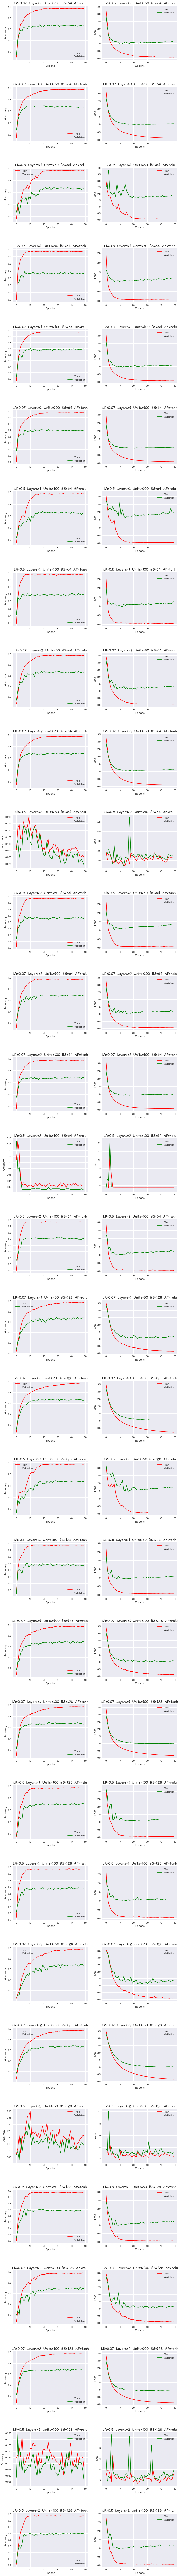

In [128]:
n = len(history)
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(n, 2, figsize=(12, 6*n))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i in range(n):
    axs[i][0].plot(history[i][0]['acc'],'r')
    axs[i][0].plot(history[i][0]['val_acc'],'g')
    axs[i][0].set_xlabel("Epochs")
    axs[i][0].set_ylabel("Accuracy")
    axs[i][0].set_title(f'LR={history[i][3]}  Layers={history[i][1]}  '
                        f'Units={history[i][2]}  BS={history[i][4]}  '
                        f'AF={history[i][-1]}',
                        fontname='Comic Sans MS',
                        fontsize=14)
    axs[i][0].legend(['Train','Validation'])

    axs[i][1].plot(history[i][0]['loss'],'r')
    axs[i][1].plot(history[i][0]['val_loss'],'g')
    axs[i][1].set_xlabel("Epochs")
    axs[i][1].set_ylabel("Loss")
    axs[i][1].set_title(f'LR={history[i][3]}  Layers={history[i][1]}  '
                        f'Units={history[i][2]}  BS={history[i][4]}  '
                        f'AF={history[i][-1]}',
                        fontname='Comic Sans MS',
                        fontsize=14)
    axs[i][1].legend(['Train','Validation'])
 

plt.savefig(PATH + 'Alphanumeric_NN.png')
plt.show()

In [131]:
conf_matrices[4]

array([[ 8,  0,  0, ...,  0,  0,  0],
       [ 0, 13,  0, ...,  0,  1,  0],
       [ 0,  0,  2, ...,  0,  1,  1],
       ...,
       [ 0,  0,  0, ...,  7,  1,  0],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  4, ...,  0,  0,  6]])